## UTKFace Experiments (Black-Box PIA)
### Load UTKFace dataset

In [1]:
from random import shuffle
import os
from keras.utils import load_img, img_to_array, to_categorical
from keras.applications.mobilenet import preprocess_input
import numpy as np


def get_gender_classes(filelist):
    gender = [i.split('_')[1] for i in filelist]

    result = []
    for i in gender:
        i = int(i)
        if i == 0:
            result.append(0)
        elif i == 1:
            result.append(1)
    return result


def get_utkface_gender_prediction_dataset(files_dir):
    onlyfiles = os.listdir(files_dir)
    #if do_shuffle:
    #    shuffle(onlyfiles)

    gender_classes = get_gender_classes(onlyfiles)

    # convert images to vectors
    X = []
    for file in onlyfiles:
        image_path = os.path.join(files_dir, file)
        rgb_image = load_img(image_path, target_size=(64, 64))
        x = img_to_array(rgb_image)
        #x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X.append(x)


    # normalize data
    #X = X.astype('float32')
    #X /= 255

    Y = to_categorical(gender_classes, num_classes=2)
    X = np.asarray(X)
    
    return X, Y, onlyfiles


2024-01-30 14:30:20.835900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 14:30:20.958182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 14:30:20.958213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 14:30:20.958807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 14:30:21.020749: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 14:30:21.021666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
utk_root = 'data/utkface'
X, Y, onlyfiles = get_utkface_gender_prediction_dataset(utk_root)

In [3]:
X[0].shape

(64, 64, 3)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### MobileNet for UTKFace

In [5]:
from keras.applications import MobileNetV3Small
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, AdamW, RMSprop, SGD
from keras.losses import CategoricalCrossentropy

mobilenet_mdl = MobileNetV3Small(
    include_top=False,
    input_shape=(64, 64, 3),
    weights="imagenet",
    alpha=0.75
)

In [6]:
def head_model(base_model, n_classes):
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(n_classes, activation="softmax")(top_model)
    return top_model

In [7]:
model_mobilenet_head = head_model(mobilenet_mdl, len(Y[0]))
model_mobilenet = Model(inputs = mobilenet_mdl.input, outputs = model_mobilenet_head)

In [42]:
for layer in model_mobilenet.layers[:-6]:
    layer.trainable = False

In [43]:
model_mobilenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 64, 64, 3)            0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 32, 32, 16)           432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 32, 32, 16)           64        ['Conv[0][0]']                
 lization)                                                                                  

In [8]:
model_mobilenet.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [9]:
history = model_mobilenet.fit(
    X_train, y_train,
    epochs=14,
    batch_size=32,
    validation_data=(X_test, y_test)
)

2024-01-30 14:30:53.130992: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 932216832 exceeds 10% of free system memory.


Epoch 1/14
593/593 [==============================] - ETA: 0s - loss: 0.7883 - accuracy: 0.6216

2024-01-30 14:31:43.652021: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 233078784 exceeds 10% of free system memory.


593/593 [==============================] - 53s 71ms/step - loss: 0.7883 - accuracy: 0.6216 - val_loss: 0.8987 - val_accuracy: 0.4793
Epoch 2/14
593/593 [==============================] - 38s 63ms/step - loss: 0.5588 - accuracy: 0.7262 - val_loss: 0.8033 - val_accuracy: 0.4795
Epoch 3/14
593/593 [==============================] - 37s 63ms/step - loss: 0.4680 - accuracy: 0.7742 - val_loss: 0.7760 - val_accuracy: 0.4755
Epoch 4/14
593/593 [==============================] - 35s 60ms/step - loss: 0.4105 - accuracy: 0.8128 - val_loss: 0.7026 - val_accuracy: 0.5291
Epoch 5/14
593/593 [==============================] - 34s 57ms/step - loss: 0.3660 - accuracy: 0.8336 - val_loss: 0.8284 - val_accuracy: 0.5367
Epoch 6/14
593/593 [==============================] - 33s 55ms/step - loss: 0.3305 - accuracy: 0.8508 - val_loss: 0.6959 - val_accuracy: 0.6438
Epoch 7/14
593/593 [==============================] - 32s 54ms/step - loss: 0.3033 - accuracy: 0.8668 - val_loss: 0.5912 - val_accuracy: 0.6917
Epo

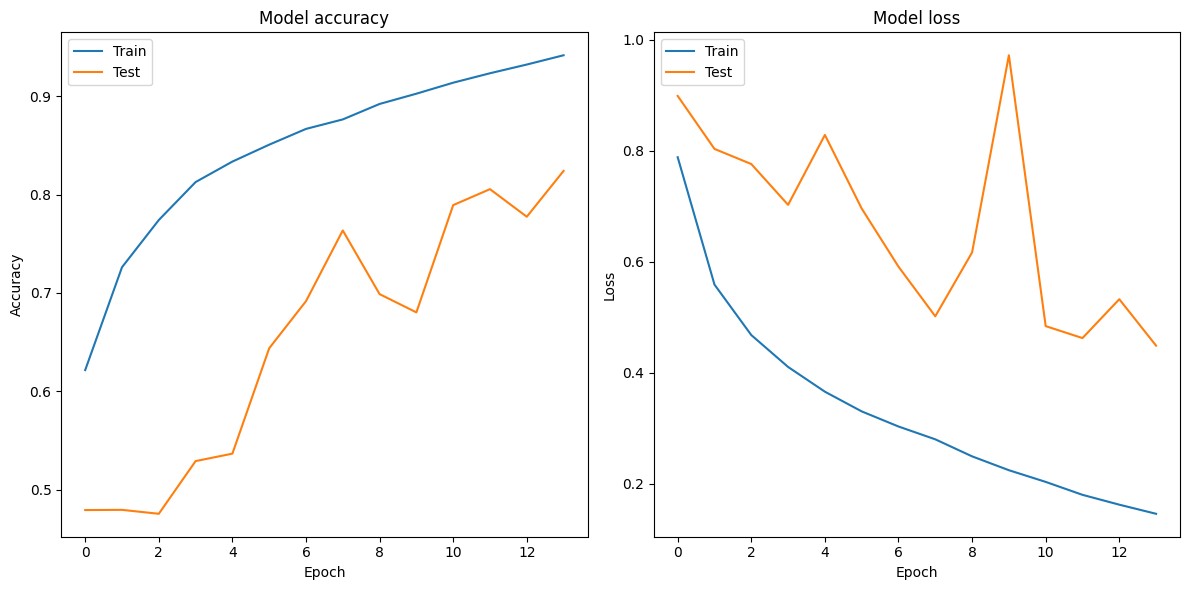

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Labelled Faces in the Wild (LFW)
used to generate the adversary input

In [16]:
import os
lfw_root = 'data/lfw-deepfunneled'
all_lfw_names = os.listdir(lfw_root)

In [17]:
from keras.utils import load_img, img_to_array
from keras.applications.mobilenet import preprocess_input
import numpy as np

X = []

for name in all_lfw_names:
    dir_path = os.path.join(lfw_root, name)
    list_images_name = os.listdir(dir_path)
    
    for image_name in list_images_name:
        image_path = os.path.join(dir_path, image_name)
        rgb_image = load_img(image_path, target_size=(64, 64))
        x = img_to_array(rgb_image)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X.append(x)

X = np.asarray(X)

In [18]:
X[0].shape

(1, 64, 64, 3)